# Sensor Anomaly Detection Use Case

## Training Model

**Note:** you must unzip the data file first

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import os

train_images=[]
train_labels=[]

# Load in the images
for filepath in os.listdir('data/NOK'):
    train_images.append(img_to_array(load_img('data/NOK/'+filepath)))
    train_labels.append(1)
    
for filepath in os.listdir('data/OK'):
    train_images.append(img_to_array(load_img('data/OK/'+filepath)))
    train_labels.append(0)
    

In [2]:
train_images=np.array(train_images)/255.
train_labels=np.array(train_labels)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

In [4]:
IMAGE_SIZE = 382

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False



In [5]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [6]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy')

In [7]:
model.fit(X_train,y_train,epochs=5, 
                    validation_data=(X_test, y_test))


Epoch 1/5
88/88 [==============================] - 87s 968ms/step - loss: 0.5421 - val_loss: 0.4472
Epoch 2/5
88/88 [==============================] - 84s 956ms/step - loss: 0.4254 - val_loss: 0.4113
Epoch 3/5
88/88 [==============================] - 84s 960ms/step - loss: 0.3890 - val_loss: 0.2667
Epoch 4/5
88/88 [==============================] - 84s 951ms/step - loss: 0.1441 - val_loss: 0.1299
Epoch 5/5
88/88 [==============================] - 85s 968ms/step - loss: 0.1133 - val_loss: 0.1178


In [8]:
tf.keras.models.save_model(model,"PARKSENSOR.h5")

## Load pre-trained model

In [9]:
import tensorflow as tf
import numpy as np

model=tf.keras.models.load_model("PARKSENSOR.h5")

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 12, 12, 1280)     2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 32)        368672    
                                                                 
 dropout (Dropout)           (None, 10, 10, 32)        0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 2,626,722
Trainable params: 368,738
Non-tr

## Performance 

In [11]:
y_predprobs=model.predict(X_test)
y_prediction=np.argmax(y_predprobs,axis=-1)

22/22 [==============================] - 17s 737ms/step


In [12]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,RocCurveDisplay

In [13]:
import pandas as pd
d=classification_report(y_test, y_prediction,output_dict=True,target_names=["OK","NOK"])
d.pop("accuracy")
pd.DataFrame(d).transpose()

,precision,recall,f1-score,support
OK,0.935401,0.989071,0.961487,366.0
NOK,0.987220,0.925150,0.955178,334.0
macro avg,0.961310,0.957110,0.958333,700.0
weighted avg,0.960126,0.958571,0.958477,700.0


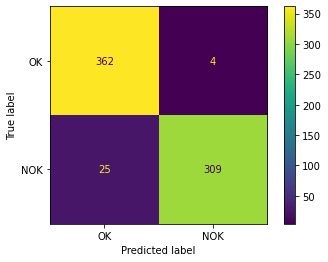

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_prediction,display_labels=["OK","NOK"])

# Explanation Strategy

If you want to view the full explanation strategy and test the methods using the iSee Explanation Experience Editor, you can import the json of the project for this usecase directly in the Editor (see SensorExplanationExperience.json). Keep in mind that the Editor is still a work in progress and it's possible that you encounter some issues. For this reason, I have included the low-level HTTP requests to the iSee Explainer Library to replicate the results. 

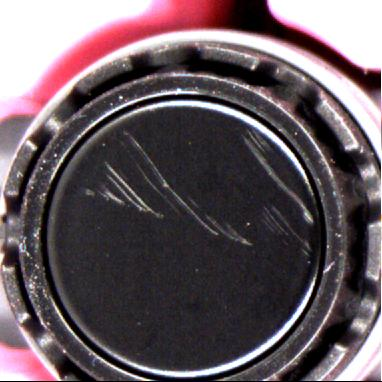

In [15]:
from PIL import Image

instance=Image.open("instance.png")
instance

In [16]:
# iSee API works with base64-encoded images

import base64
from io import BytesIO
from PIL import Image

def PIL_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue())
    return img_str.decode("utf-8")

def base64_to_PIL(b64_str):
    img=b64_str.encode("utf-8")
    image_bytes=base64.b64decode(img)
    img=Image.open(BytesIO(image_bytes))
    return img

instance=PIL_to_base64(instance)

In [17]:
# preparing the generic body of the requests

import requests
import json
import copy

#If running locally, change to "http://localhost:5000/Timeseries/"
base_url = "https://explainers-dev.isee4xai.com/Images/"

base_payload = {
  "instance": instance,
  "size_raw": [
    382,
    382
  ],
  "type": "image",
  "id": "PARKSENSOR" #id of the case uploaded to iSee
}
headers = {
  'Content-Type': 'application/json'
}





### Grad-CAM

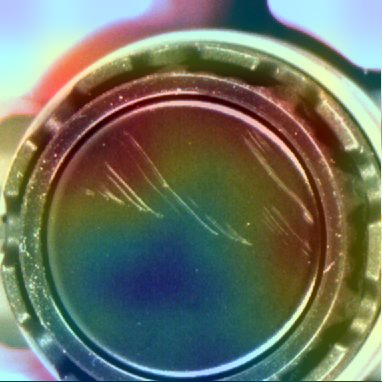

In [19]:
url=base_url+"GradCam"

response = requests.request("POST", url, headers=headers, data=json.dumps(base_payload))
base64_to_PIL(json.loads(response.text)["explanation"])

### Integrated Gradients

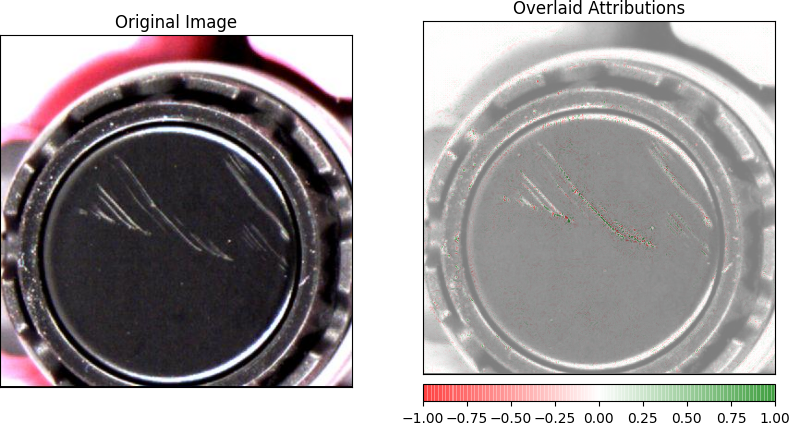

In [20]:
url=base_url+"IntegratedGradients"

payload=copy.deepcopy(base_payload)
payload["params"]={
    "plot_type": "attributions"
  }

response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
base64_to_PIL(json.loads(response.text)["explanation"])

### LIME

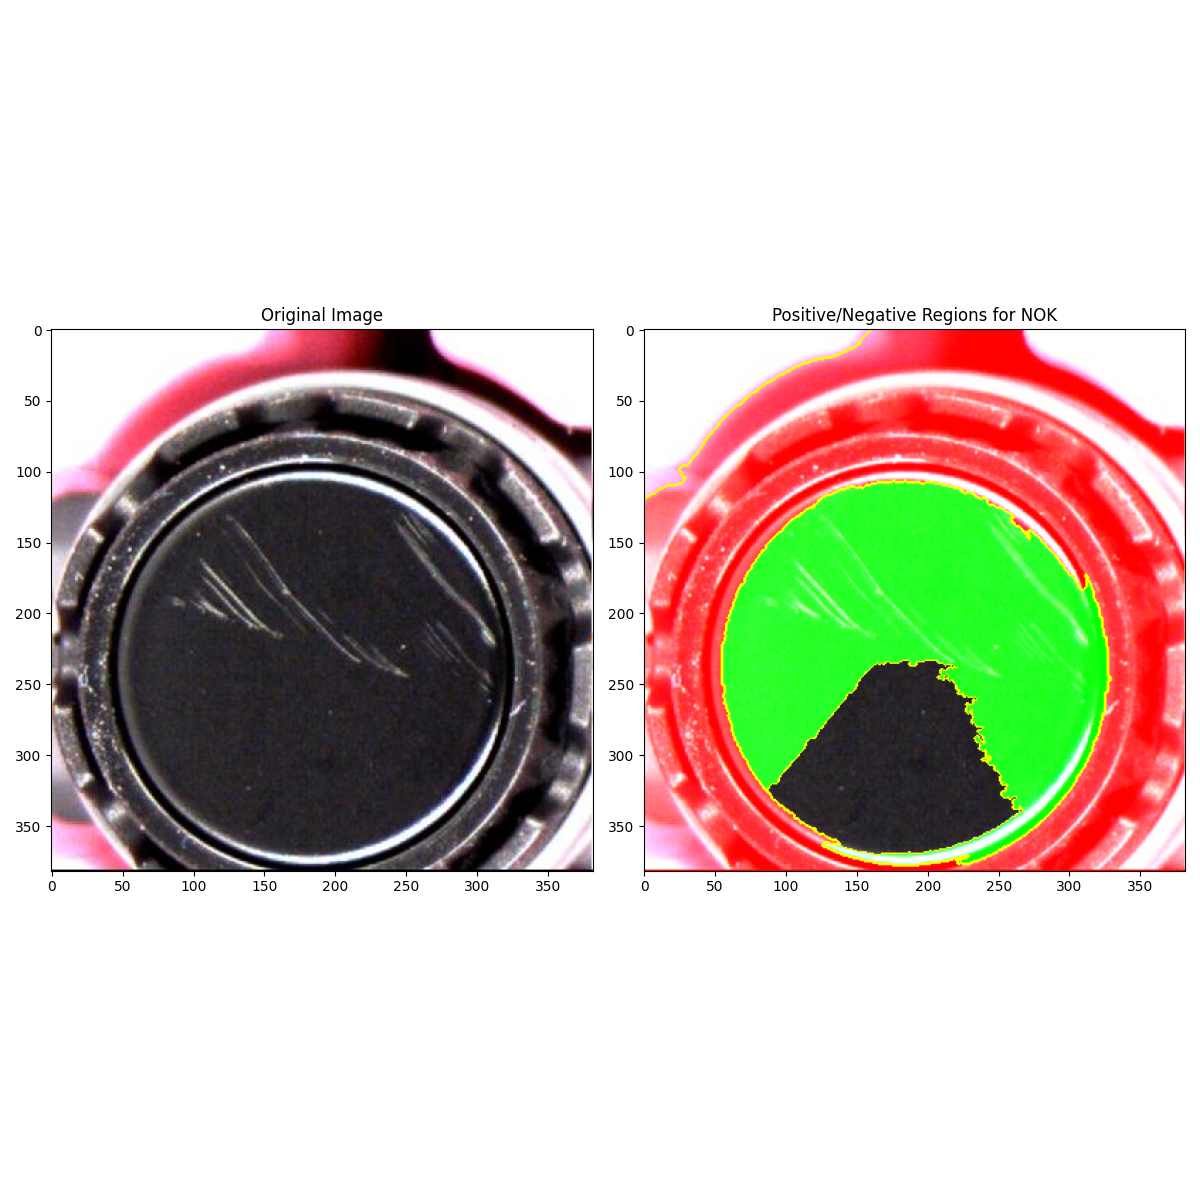

In [21]:
url=base_url+"LIME"

payload=copy.deepcopy(base_payload)
payload["params"]={
    "segmentation_fn":"slic",
    "n_segments":15
}

response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
base64_to_PIL(json.loads(response.text)["explanation"])

### Anchors

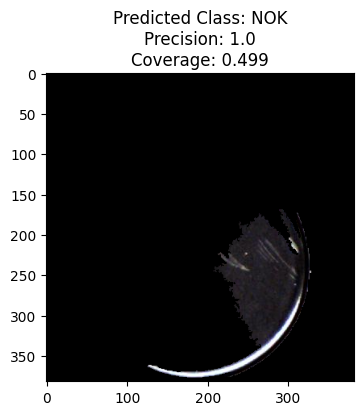

In [22]:
url=base_url+"Anchors"

payload=copy.deepcopy(base_payload)
payload["params"]={
    "threshold":1,
    "delta":0.001,
    "segmentation_fn":"slic",
    "n_segments":15
}

response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
base64_to_PIL(json.loads(response.text)["explanation"])

### Nearest Neigbours

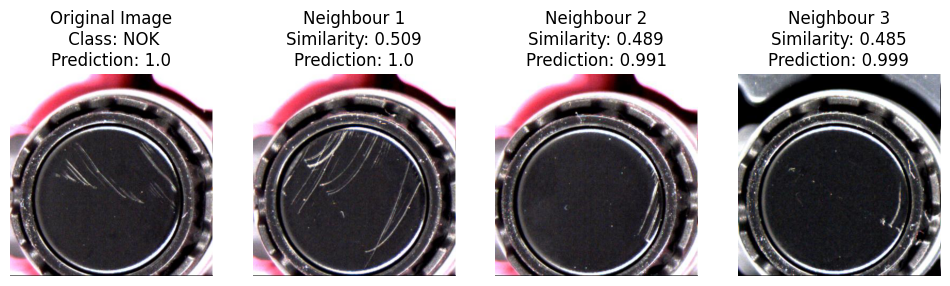

In [23]:
url=base_url+"SSIMNearestNeighbours"

payload["params"]={
    "no_neighbours":3,
    #"sample": 100
  }

response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
base64_to_PIL(json.loads(response.text)["explanation"])

### In-sample Counterfactuals

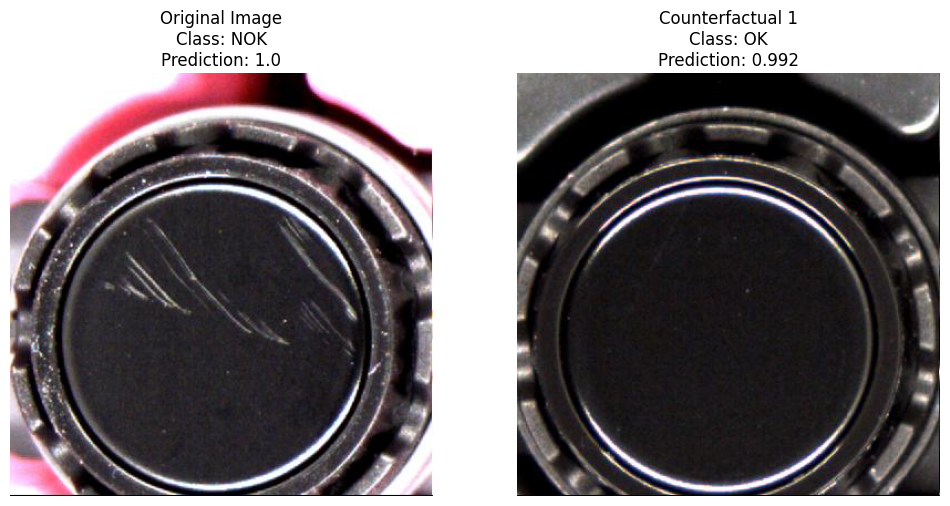

In [24]:
url=base_url+"SSIMCounterfactuals"

payload["params"]={
    "num_cf":1,
    #"sample": 100
  }

response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
base64_to_PIL(json.loads(response.text)["explanation"])